In [ ]:
# https://github.com/huggingface/peft/blob/main/examples/sequence_classification/Prompt_Tuning.ipynb
# https://github.com/peremartra/Large-Language-Model-Notebooks-Course/blob/main/5-Fine%20Tuning/Prompt_Tuning_PEFT.ipynb
# https://huggingface.co/docs/peft/main/en/task_guides/clm-prompt-tuning

In [ ]:
!pip install accelerate -U
!pip install transformers datasets evaluate accelerate peft

In [ ]:
from google.colab import drive
import pandas as pd
import os
import torch
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from peft import (
    get_peft_config,
    get_peft_model,
    get_peft_model_state_dict,
    set_peft_model_state_dict,
    PromptTuningConfig,
    PeftType,
    PrefixTuningConfig,
    PromptEncoderConfig,
)

In [ ]:
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/Comp545_FinalProject/code')

from model.train import training_loop
from model.evaluate import evaluate_model
from utils.funcs import load_data, load_tokenizer_model, prepare_dataloader
from utils.plot import plot_confusion_matrix
from utils.test_cases import run_test_cases

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Train and evaluate on combine data

In [ ]:
train_combine_data_path = "../data_PEFT/lab-manual-combine-train.xlsx"
test_combine_data_path = "../data_PEFT/lab-manual-combine-test.xlsx"

sentences_combine, labels_combine, sentences_test_combine, labels_test_combine = load_data(train_combine_data_path, test_combine_data_path)

In [ ]:
language_model_to_use = 'roberta-large'
batch_size = 16

train_val_dataloader_combine = prepare_dataloader(language_model_to_use, sentences_combine, labels_combine, batch_size, device, return_train_dataloader=True)
test_dataloader_combine = prepare_dataloader(language_model_to_use, sentences_test_combine, labels_test_combine, batch_size, device, return_train_dataloader=False)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Size: 4568, Validation Size: 1141


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Size: 1428


https://huggingface.co/docs/peft/en/package_reference/prompt_tuning

In [ ]:
peft_config = PromptTuningConfig(task_type="SEQ_CLS", peft_type="PROMPT_TUNING", num_virtual_tokens=10)

tokenizer, model = load_tokenizer_model(language_model_to_use, device)
model_prompt_tuning = get_peft_model(model, peft_config)
model_prompt_tuning.print_trainable_parameters()
# model_prompt_tuning
# trainable params: 1,062,915 || all params: 356,425,734 || trainable%: 0.2982149992570402

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,062,915 || all params: 356,425,734 || trainable%: 0.2982149992570402


In [ ]:
optimizer = AdamW(params=model.parameters(), lr=1e-3)
num_epochs = 20
num_training_steps = len(train_val_dataloader_combine['train']) * num_epochs

# Instantiate scheduler
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0.06 * (len(train_val_dataloader_combine['train']) * num_epochs),
    num_training_steps=num_training_steps,
)

In [ ]:
accuracy_list, f1_list = training_loop(model_prompt_tuning, device, num_epochs, train_val_dataloader_combine, optimizer, lr_scheduler)

100%|██████████| 286/286 [07:53<00:00,  1.66s/it]


Epoch [1/20], Training loss: 1.1235


100%|██████████| 72/72 [01:02<00:00,  1.16it/s]


Epoch [1/20], Validation accuracy:
{'accuracy': 0.4119193689745837}
Epoch [1/20], Validation f1:
{'f1': 0.35752182090553036}
---------------------------------------------------


100%|██████████| 286/286 [07:40<00:00,  1.61s/it]


Epoch [2/20], Training loss: 1.0561


100%|██████████| 72/72 [01:02<00:00,  1.16it/s]


Epoch [2/20], Validation accuracy:
{'accuracy': 0.5241016652059597}
Epoch [2/20], Validation f1:
{'f1': 0.45054305354692953}
---------------------------------------------------


100%|██████████| 286/286 [07:40<00:00,  1.61s/it]


Epoch [3/20], Training loss: 0.9706


100%|██████████| 72/72 [01:02<00:00,  1.16it/s]


Epoch [3/20], Validation accuracy:
{'accuracy': 0.5205959684487291}
Epoch [3/20], Validation f1:
{'f1': 0.4245464984778701}
---------------------------------------------------


100%|██████████| 286/286 [07:40<00:00,  1.61s/it]


Epoch [4/20], Training loss: 1.0599


100%|██████████| 72/72 [01:02<00:00,  1.16it/s]


Epoch [4/20], Validation accuracy:
{'accuracy': 0.5153374233128835}
Epoch [4/20], Validation f1:
{'f1': 0.3945438571740542}
---------------------------------------------------


100%|██████████| 286/286 [07:40<00:00,  1.61s/it]


Epoch [5/20], Training loss: 1.0194


100%|██████████| 72/72 [01:02<00:00,  1.16it/s]


Epoch [5/20], Validation accuracy:
{'accuracy': 0.5241016652059597}
Epoch [5/20], Validation f1:
{'f1': 0.4742012518507838}
---------------------------------------------------


100%|██████████| 286/286 [07:41<00:00,  1.61s/it]


Epoch [6/20], Training loss: 0.6981


100%|██████████| 72/72 [01:02<00:00,  1.16it/s]


Epoch [6/20], Validation accuracy:
{'accuracy': 0.5065731814198072}
Epoch [6/20], Validation f1:
{'f1': 0.39087945456519474}
---------------------------------------------------


100%|██████████| 286/286 [07:40<00:00,  1.61s/it]


Epoch [7/20], Training loss: 0.9922


100%|██████████| 72/72 [01:02<00:00,  1.16it/s]


Epoch [7/20], Validation accuracy:
{'accuracy': 0.5337423312883436}
Epoch [7/20], Validation f1:
{'f1': 0.4561695560224007}
---------------------------------------------------


100%|██████████| 286/286 [07:40<00:00,  1.61s/it]


Epoch [8/20], Training loss: 1.0255


100%|██████████| 72/72 [01:02<00:00,  1.16it/s]


Epoch [8/20], Validation accuracy:
{'accuracy': 0.5486415425065732}
Epoch [8/20], Validation f1:
{'f1': 0.4774783228406919}
---------------------------------------------------


100%|██████████| 286/286 [07:41<00:00,  1.61s/it]


Epoch [9/20], Training loss: 0.6571


100%|██████████| 72/72 [01:01<00:00,  1.16it/s]


Epoch [9/20], Validation accuracy:
{'accuracy': 0.5539000876424189}
Epoch [9/20], Validation f1:
{'f1': 0.5033467514907777}
---------------------------------------------------


100%|██████████| 286/286 [07:40<00:00,  1.61s/it]


Epoch [10/20], Training loss: 0.8219


100%|██████████| 72/72 [01:02<00:00,  1.16it/s]


Epoch [10/20], Validation accuracy:
{'accuracy': 0.5872042068361086}
Epoch [10/20], Validation f1:
{'f1': 0.5873186854092091}
---------------------------------------------------


100%|██████████| 286/286 [07:40<00:00,  1.61s/it]


Epoch [11/20], Training loss: 1.1352


100%|██████████| 72/72 [01:02<00:00,  1.16it/s]


Epoch [11/20], Validation accuracy:
{'accuracy': 0.5731814198071867}
Epoch [11/20], Validation f1:
{'f1': 0.5702432627406089}
---------------------------------------------------


100%|██████████| 286/286 [07:41<00:00,  1.61s/it]


Epoch [12/20], Training loss: 0.7783


100%|██████████| 72/72 [01:02<00:00,  1.16it/s]


Epoch [12/20], Validation accuracy:
{'accuracy': 0.5985977212971078}
Epoch [12/20], Validation f1:
{'f1': 0.5842249759918502}
---------------------------------------------------


100%|██████████| 286/286 [07:41<00:00,  1.61s/it]


Epoch [13/20], Training loss: 0.6006


100%|██████████| 72/72 [01:02<00:00,  1.16it/s]


Epoch [13/20], Validation accuracy:
{'accuracy': 0.5731814198071867}
Epoch [13/20], Validation f1:
{'f1': 0.5773287083099784}
---------------------------------------------------


100%|██████████| 286/286 [07:41<00:00,  1.61s/it]


Epoch [14/20], Training loss: 0.8872


100%|██████████| 72/72 [01:02<00:00,  1.16it/s]


Epoch [14/20], Validation accuracy:
{'accuracy': 0.6021034180543383}
Epoch [14/20], Validation f1:
{'f1': 0.5791642175044013}
---------------------------------------------------


100%|██████████| 286/286 [07:40<00:00,  1.61s/it]


Epoch [15/20], Training loss: 0.6001


100%|██████████| 72/72 [01:02<00:00,  1.16it/s]


Epoch [15/20], Validation accuracy:
{'accuracy': 0.6240140227870289}
Epoch [15/20], Validation f1:
{'f1': 0.6215374083137738}
---------------------------------------------------


100%|██████████| 286/286 [07:40<00:00,  1.61s/it]


Epoch [16/20], Training loss: 0.7653


100%|██████████| 72/72 [01:01<00:00,  1.16it/s]


Epoch [16/20], Validation accuracy:
{'accuracy': 0.5942156003505696}
Epoch [16/20], Validation f1:
{'f1': 0.5703900438728997}
---------------------------------------------------


100%|██████████| 286/286 [07:40<00:00,  1.61s/it]


Epoch [17/20], Training loss: 0.9620


100%|██████████| 72/72 [01:01<00:00,  1.16it/s]


Epoch [17/20], Validation accuracy:
{'accuracy': 0.5985977212971078}
Epoch [17/20], Validation f1:
{'f1': 0.5711467758373264}
---------------------------------------------------


100%|██████████| 286/286 [07:40<00:00,  1.61s/it]


Epoch [18/20], Training loss: 0.9203


100%|██████████| 72/72 [01:01<00:00,  1.17it/s]


Epoch [18/20], Validation accuracy:
{'accuracy': 0.6108676599474145}
Epoch [18/20], Validation f1:
{'f1': 0.5840221748412091}
---------------------------------------------------


100%|██████████| 286/286 [07:40<00:00,  1.61s/it]


Epoch [19/20], Training loss: 0.6848


100%|██████████| 72/72 [01:01<00:00,  1.17it/s]


Epoch [19/20], Validation accuracy:
{'accuracy': 0.6310254163014899}
Epoch [19/20], Validation f1:
{'f1': 0.6234077922533836}
---------------------------------------------------


100%|██████████| 286/286 [07:40<00:00,  1.61s/it]


Epoch [20/20], Training loss: 1.2303


100%|██████████| 72/72 [01:02<00:00,  1.16it/s]

Epoch [20/20], Validation accuracy:
{'accuracy': 0.628396143733567}
Epoch [20/20], Validation f1:
{'f1': 0.6227050754597597}
---------------------------------------------------


In [ ]:
accuracy_list

[{'accuracy': 0.4119193689745837},
 {'accuracy': 0.5241016652059597},
 {'accuracy': 0.5205959684487291},
 {'accuracy': 0.5153374233128835},
 {'accuracy': 0.5241016652059597},
 {'accuracy': 0.5065731814198072},
 {'accuracy': 0.5337423312883436},
 {'accuracy': 0.5486415425065732},
 {'accuracy': 0.5539000876424189},
 {'accuracy': 0.5872042068361086},
 {'accuracy': 0.5731814198071867},
 {'accuracy': 0.5985977212971078},
 {'accuracy': 0.5731814198071867},
 {'accuracy': 0.6021034180543383},
 {'accuracy': 0.6240140227870289},
 {'accuracy': 0.5942156003505696},
 {'accuracy': 0.5985977212971078},
 {'accuracy': 0.6108676599474145},
 {'accuracy': 0.6310254163014899},
 {'accuracy': 0.628396143733567}]

In [ ]:
f1_list

[{'f1': 0.35752182090553036},
 {'f1': 0.45054305354692953},
 {'f1': 0.4245464984778701},
 {'f1': 0.3945438571740542},
 {'f1': 0.4742012518507838},
 {'f1': 0.39087945456519474},
 {'f1': 0.4561695560224007},
 {'f1': 0.4774783228406919},
 {'f1': 0.5033467514907777},
 {'f1': 0.5873186854092091},
 {'f1': 0.5702432627406089},
 {'f1': 0.5842249759918502},
 {'f1': 0.5773287083099784},
 {'f1': 0.5791642175044013},
 {'f1': 0.6215374083137738},
 {'f1': 0.5703900438728997},
 {'f1': 0.5711467758373264},
 {'f1': 0.5840221748412091},
 {'f1': 0.6234077922533836},
 {'f1': 0.6227050754597597}]

In [ ]:
accuracy, f1, predictions_list, labels_list = evaluate_model(model_prompt_tuning, test_dataloader_combine, device)

Test accuracy:  {'accuracy': 0.6253501400560224}
Test f1:  {'f1': 0.6212130623737788}


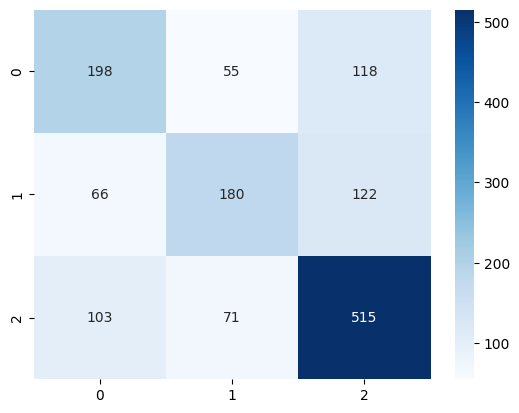

In [ ]:
plot_confusion_matrix(labels_list, predictions_list)

In [ ]:
# test some cases
prompt_tuning_model_combinedata_name = 'prompt_tuning-model-combinedata'
prompt_tuning_tokenizer_combinedata_name = 'prompt_tuning-tokenizer-combinedata'

# Save model
tokenizer.save_pretrained(prompt_tuning_tokenizer_combinedata_name)
model_prompt_tuning.save_pretrained(prompt_tuning_model_combinedata_name)

run_test_cases(prompt_tuning_model_combinedata_name, prompt_tuning_tokenizer_combinedata_name)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Example 1
The Committee anticipates that ongoing increases in the target range for the federal funds rate will be appropriate.
correct answer: Hawkish
predicted classification:  Dovish
Example 2
In light of the softer economic outlook, we will maintain the current federal funds rate.
correct answer: Dovish
predicted classification:  Neutral
Example 3
Economic activity has been rising at a strong rate.
correct answer: Neutral
predicted classification:  Hawkish
Example 4
Considering the elevated inflation pressures, we may consider further rate hikes.
correct answer: Hawkish
predicted classification:  Neutral
Example 5
The labor market continues to strengthen, but inflation remains below our 2 percent longer-run objective.
correct answer: Dovish
predicted classification:  Dovish


## Train and evaluate on split combine data

In [ ]:
train_split_combine_data_path = "../data_PEFT/lab-manual-split-combine-train.xlsx"
test_split_combine_data_path = "../data_PEFT/lab-manual-split-combine-test.xlsx"

sentences_split_combine, labels_split_combine, sentences_test_split_combine, labels_test_split_combine = load_data(train_split_combine_data_path,
                                                                                                                   test_split_combine_data_path)

In [ ]:
language_model_to_use = 'roberta-large'
batch_size = 16

train_val_dataloader_split_combine = prepare_dataloader(language_model_to_use,
                                                        sentences_split_combine,
                                                        labels_split_combine,
                                                        batch_size,
                                                        device,
                                                        return_train_dataloader=True)
test_dataloader_split_combine = prepare_dataloader(language_model_to_use,
                                                   sentences_test_split_combine,
                                                   labels_test_split_combine,
                                                   batch_size,
                                                   device,
                                                   return_train_dataloader=False)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Size: 4762, Validation Size: 1190


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Size: 1488


In [ ]:
peft_config = PromptTuningConfig(task_type="SEQ_CLS", peft_type="PROMPT_TUNING", num_virtual_tokens=10)

tokenizer, model = load_tokenizer_model(language_model_to_use, device)
model_prompt_tuning = get_peft_model(model, peft_config)
model_prompt_tuning.print_trainable_parameters()
# model_prompt_tuning
# trainable params: 1,062,915 || all params: 356,425,734 || trainable%: 0.2982149992570402

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,062,915 || all params: 356,425,734 || trainable%: 0.2982149992570402


In [ ]:
optimizer = AdamW(params=model.parameters(), lr=1e-3)
num_epochs = 20
num_training_steps = len(train_val_dataloader_split_combine['train']) * num_epochs

# Instantiate scheduler
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0.06 * (len(train_val_dataloader_split_combine['train']) * num_epochs),
    num_training_steps=num_training_steps,
)

In [ ]:
accuracy_list_splitdata, f1_list_splitdata = training_loop(model_prompt_tuning,
                                                           device,
                                                           num_epochs,
                                                           train_val_dataloader_split_combine,
                                                           optimizer,
                                                           lr_scheduler)

100%|██████████| 298/298 [08:12<00:00,  1.65s/it]


Epoch [1/20], Training loss: 1.3209


100%|██████████| 75/75 [01:04<00:00,  1.16it/s]


Epoch [1/20], Validation accuracy:
{'accuracy': 0.492436974789916}
Epoch [1/20], Validation f1:
{'f1': 0.3441505741217267}
---------------------------------------------------


100%|██████████| 298/298 [08:00<00:00,  1.61s/it]


Epoch [2/20], Training loss: 1.0221


100%|██████████| 75/75 [01:04<00:00,  1.16it/s]


Epoch [2/20], Validation accuracy:
{'accuracy': 0.5058823529411764}
Epoch [2/20], Validation f1:
{'f1': 0.3871405637638599}
---------------------------------------------------


100%|██████████| 298/298 [07:59<00:00,  1.61s/it]


Epoch [3/20], Training loss: 1.1551


100%|██████████| 75/75 [01:04<00:00,  1.16it/s]


Epoch [3/20], Validation accuracy:
{'accuracy': 0.515126050420168}
Epoch [3/20], Validation f1:
{'f1': 0.4468849849420522}
---------------------------------------------------


100%|██████████| 298/298 [07:59<00:00,  1.61s/it]


Epoch [4/20], Training loss: 0.8907


100%|██████████| 75/75 [01:04<00:00,  1.16it/s]


Epoch [4/20], Validation accuracy:
{'accuracy': 0.5243697478991597}
Epoch [4/20], Validation f1:
{'f1': 0.5016500867189816}
---------------------------------------------------


100%|██████████| 298/298 [08:00<00:00,  1.61s/it]


Epoch [5/20], Training loss: 0.8820


100%|██████████| 75/75 [01:04<00:00,  1.16it/s]


Epoch [5/20], Validation accuracy:
{'accuracy': 0.5361344537815126}
Epoch [5/20], Validation f1:
{'f1': 0.5321560817869345}
---------------------------------------------------


100%|██████████| 298/298 [08:00<00:00,  1.61s/it]


Epoch [6/20], Training loss: 0.9496


100%|██████████| 75/75 [01:04<00:00,  1.16it/s]


Epoch [6/20], Validation accuracy:
{'accuracy': 0.5352941176470588}
Epoch [6/20], Validation f1:
{'f1': 0.44876495603285804}
---------------------------------------------------


100%|██████████| 298/298 [07:59<00:00,  1.61s/it]


Epoch [7/20], Training loss: 0.5626


100%|██████████| 75/75 [01:04<00:00,  1.16it/s]


Epoch [7/20], Validation accuracy:
{'accuracy': 0.5243697478991597}
Epoch [7/20], Validation f1:
{'f1': 0.445158763038168}
---------------------------------------------------


100%|██████████| 298/298 [08:00<00:00,  1.61s/it]


Epoch [8/20], Training loss: 0.8615


100%|██████████| 75/75 [01:04<00:00,  1.16it/s]


Epoch [8/20], Validation accuracy:
{'accuracy': 0.5512605042016807}
Epoch [8/20], Validation f1:
{'f1': 0.47622959448074104}
---------------------------------------------------


100%|██████████| 298/298 [08:00<00:00,  1.61s/it]


Epoch [9/20], Training loss: 0.8013


100%|██████████| 75/75 [01:04<00:00,  1.16it/s]


Epoch [9/20], Validation accuracy:
{'accuracy': 0.5722689075630252}
Epoch [9/20], Validation f1:
{'f1': 0.5449738274337448}
---------------------------------------------------


100%|██████████| 298/298 [07:59<00:00,  1.61s/it]


Epoch [10/20], Training loss: 0.9266


100%|██████████| 75/75 [01:04<00:00,  1.16it/s]


Epoch [10/20], Validation accuracy:
{'accuracy': 0.5747899159663865}
Epoch [10/20], Validation f1:
{'f1': 0.5575842671230803}
---------------------------------------------------


100%|██████████| 298/298 [08:00<00:00,  1.61s/it]


Epoch [11/20], Training loss: 0.7723


100%|██████████| 75/75 [01:04<00:00,  1.16it/s]


Epoch [11/20], Validation accuracy:
{'accuracy': 0.5436974789915966}
Epoch [11/20], Validation f1:
{'f1': 0.528970843501775}
---------------------------------------------------


100%|██████████| 298/298 [07:59<00:00,  1.61s/it]


Epoch [12/20], Training loss: 0.8189


100%|██████████| 75/75 [01:04<00:00,  1.16it/s]


Epoch [12/20], Validation accuracy:
{'accuracy': 0.5386554621848739}
Epoch [12/20], Validation f1:
{'f1': 0.5425387939094637}
---------------------------------------------------


100%|██████████| 298/298 [07:59<00:00,  1.61s/it]


Epoch [13/20], Training loss: 0.6461


100%|██████████| 75/75 [01:04<00:00,  1.16it/s]


Epoch [13/20], Validation accuracy:
{'accuracy': 0.5369747899159664}
Epoch [13/20], Validation f1:
{'f1': 0.5047132109245376}
---------------------------------------------------


100%|██████████| 298/298 [07:59<00:00,  1.61s/it]


Epoch [14/20], Training loss: 0.7322


100%|██████████| 75/75 [01:04<00:00,  1.16it/s]


Epoch [14/20], Validation accuracy:
{'accuracy': 0.5991596638655462}
Epoch [14/20], Validation f1:
{'f1': 0.5807303984346819}
---------------------------------------------------


100%|██████████| 298/298 [07:59<00:00,  1.61s/it]


Epoch [15/20], Training loss: 0.6899


100%|██████████| 75/75 [01:04<00:00,  1.16it/s]


Epoch [15/20], Validation accuracy:
{'accuracy': 0.6058823529411764}
Epoch [15/20], Validation f1:
{'f1': 0.572440898464852}
---------------------------------------------------


100%|██████████| 298/298 [07:59<00:00,  1.61s/it]


Epoch [16/20], Training loss: 0.5776


100%|██████████| 75/75 [01:04<00:00,  1.16it/s]


Epoch [16/20], Validation accuracy:
{'accuracy': 0.611764705882353}
Epoch [16/20], Validation f1:
{'f1': 0.5987388970301465}
---------------------------------------------------


100%|██████████| 298/298 [07:59<00:00,  1.61s/it]


Epoch [17/20], Training loss: 0.7560


100%|██████████| 75/75 [01:04<00:00,  1.16it/s]


Epoch [17/20], Validation accuracy:
{'accuracy': 0.6218487394957983}
Epoch [17/20], Validation f1:
{'f1': 0.6033428852184736}
---------------------------------------------------


100%|██████████| 298/298 [08:00<00:00,  1.61s/it]


Epoch [18/20], Training loss: 0.8486


100%|██████████| 75/75 [01:04<00:00,  1.16it/s]


Epoch [18/20], Validation accuracy:
{'accuracy': 0.619327731092437}
Epoch [18/20], Validation f1:
{'f1': 0.6094119847929467}
---------------------------------------------------


100%|██████████| 298/298 [07:59<00:00,  1.61s/it]


Epoch [19/20], Training loss: 0.7179


100%|██████████| 75/75 [01:04<00:00,  1.16it/s]


Epoch [19/20], Validation accuracy:
{'accuracy': 0.6302521008403361}
Epoch [19/20], Validation f1:
{'f1': 0.6226958256858521}
---------------------------------------------------


100%|██████████| 298/298 [07:59<00:00,  1.61s/it]


Epoch [20/20], Training loss: 0.7383


100%|██████████| 75/75 [01:04<00:00,  1.16it/s]

Epoch [20/20], Validation accuracy:
{'accuracy': 0.6302521008403361}
Epoch [20/20], Validation f1:
{'f1': 0.6214184712335341}
---------------------------------------------------


In [ ]:
accuracy_list_splitdata

[{'accuracy': 0.492436974789916},
 {'accuracy': 0.5058823529411764},
 {'accuracy': 0.515126050420168},
 {'accuracy': 0.5243697478991597},
 {'accuracy': 0.5361344537815126},
 {'accuracy': 0.5352941176470588},
 {'accuracy': 0.5243697478991597},
 {'accuracy': 0.5512605042016807},
 {'accuracy': 0.5722689075630252},
 {'accuracy': 0.5747899159663865},
 {'accuracy': 0.5436974789915966},
 {'accuracy': 0.5386554621848739},
 {'accuracy': 0.5369747899159664},
 {'accuracy': 0.5991596638655462},
 {'accuracy': 0.6058823529411764},
 {'accuracy': 0.611764705882353},
 {'accuracy': 0.6218487394957983},
 {'accuracy': 0.619327731092437},
 {'accuracy': 0.6302521008403361},
 {'accuracy': 0.6302521008403361}]

In [ ]:
f1_list_splitdata

[{'f1': 0.3441505741217267},
 {'f1': 0.3871405637638599},
 {'f1': 0.4468849849420522},
 {'f1': 0.5016500867189816},
 {'f1': 0.5321560817869345},
 {'f1': 0.44876495603285804},
 {'f1': 0.445158763038168},
 {'f1': 0.47622959448074104},
 {'f1': 0.5449738274337448},
 {'f1': 0.5575842671230803},
 {'f1': 0.528970843501775},
 {'f1': 0.5425387939094637},
 {'f1': 0.5047132109245376},
 {'f1': 0.5807303984346819},
 {'f1': 0.572440898464852},
 {'f1': 0.5987388970301465},
 {'f1': 0.6033428852184736},
 {'f1': 0.6094119847929467},
 {'f1': 0.6226958256858521},
 {'f1': 0.6214184712335341}]

In [ ]:
accuracy_splitdata, f1_splitdata, predictions_list_splitdata, labels_list_splitdata = evaluate_model(model_prompt_tuning,
                                                                                                     test_dataloader_split_combine,
                                                                                                     device)

Test accuracy:  {'accuracy': 0.614247311827957}
Test f1:  {'f1': 0.6100082593112046}


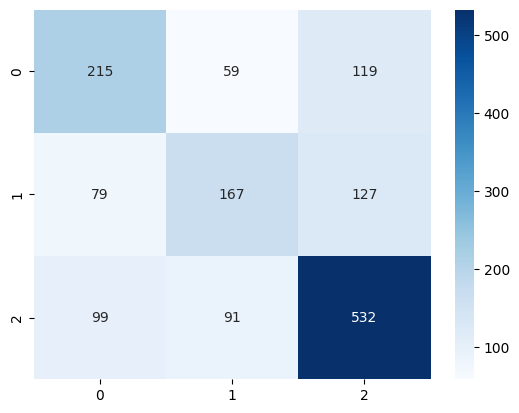

In [ ]:
plot_confusion_matrix(labels_list_splitdata, predictions_list_splitdata)

In [ ]:
# test some cases
prompt_tuning_model_splitdata_name = 'prompt_tuning-model-splitdata'
prompt_tuning_tokenizer_splitdata_name = 'prompt_tuning-tokenizer-splitdata'

# Save model
tokenizer.save_pretrained(prompt_tuning_tokenizer_splitdata_name)
model_prompt_tuning.save_pretrained(prompt_tuning_model_splitdata_name)

run_test_cases(prompt_tuning_model_splitdata_name, prompt_tuning_tokenizer_splitdata_name)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Example 1
The Committee anticipates that ongoing increases in the target range for the federal funds rate will be appropriate.
correct answer: Hawkish
predicted classification:  Neutral
Example 2
In light of the softer economic outlook, we will maintain the current federal funds rate.
correct answer: Dovish
predicted classification:  Neutral
Example 3
Economic activity has been rising at a strong rate.
correct answer: Neutral
predicted classification:  Hawkish
Example 4
Considering the elevated inflation pressures, we may consider further rate hikes.
correct answer: Hawkish
predicted classification:  Neutral
Example 5
The labor market continues to strengthen, but inflation remains below our 2 percent longer-run objective.
correct answer: Dovish
predicted classification:  Hawkish
